In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

---

# Regression modeling

A general, primary goal of many statistical data analysis tasks is to relate the influence of one variable on another. 

For example: 

- how different medical interventions influence the incidence or duration of disease
- how baseball player's performance varies as a function of age.
- [how test scores are correlated with tissue LSD concentration](http://www.lycaeum.org/research/researchpdfs/1748.pdf)

In [2]:
from io import StringIO

data_string = """
Drugs	Score
0	1.17	78.93
1	2.97	58.20
2	3.26	67.47
3	4.69	37.47
4	5.83	45.65
5	6.00	32.92
6	6.41	29.97
"""

lsd_and_math = pd.read_table(StringIO(data_string), sep='\t', index_col=0)
lsd_and_math

,Drugs,Score
0,1.17,78.93
1,2.97,58.20
2,3.26,67.47
3,4.69,37.47
4,5.83,45.65
5,6.00,32.92
6,6.41,29.97


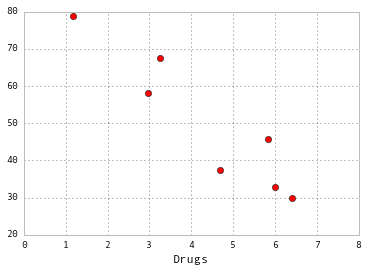

In [3]:
lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))

We can build a model to characterize the relationship between $X$ and $Y$, recognizing that additional factors other than $X$ (the ones we have measured or are interested in) may influence the response variable $Y$.

- $M(Y|X) = E(Y|X)$
- $M(Y|X) = Pr(Y=1|X)$

In general,

$$M(Y|X) = f(X)$$

for linear regression

$$M(Y|X) = f(X\beta)$$

where $f$ is some function, for example a linear function:

<div style="font-size: 150%;">  
$y_i = \beta_0 + \beta_1 x_{1i} + \ldots + \beta_k x_{ki} + \epsilon_i$
</div>

Regression is a **weighted sum** of independent predictors

and $\epsilon_i$ accounts for the difference between the observed response $y_i$ and its prediction from the model $\hat{y_i} = \beta_0 + \beta_1 x_i$. This is sometimes referred to as **process uncertainty**.

Coefficients represent the change in Y for a unit increment of the predictor X.

Two important regression **assumptions**:

1. normal errors
2. homoscedasticity


## Parameter estimation

We would like to select $\beta_0, \beta_1$ so that the difference between the predictions and the observations is zero, but this is not usually possible. Instead, we choose a reasonable criterion: ***the smallest sum of the squared differences between $\hat{y}$ and $y$***.

<div style="font-size: 120%;">  
$$R^2 = \sum_i (y_i - [\beta_0 + \beta_1 x_i])^2 = \sum_i \epsilon_i^2 $$  
</div>

Squaring serves two purposes: 

1. to prevent positive and negative values from cancelling each other out
2. to strongly penalize large deviations. 

Whether or not the latter is a desired depends on the goals of the analysis.

In other words, we will select the parameters that minimize the squared error of the model.

In [4]:
sum_of_squares = lambda theta, x, y: np.sum((y - theta[0] - theta[1]*x) ** 2)

In [5]:
sum_of_squares([0,1], lsd_and_math.Drugs, lsd_and_math.Score)

17159.8154

In [6]:
x, y = lsd_and_math.T.values
b0, b1 = fmin(sum_of_squares, [0,1], args=(x,y))
b0, b1

Optimization terminated successfully.
         Current function value: 253.881329
         Iterations: 97
         Function evaluations: 179


(89.123909209804239, -9.0094696583309499)

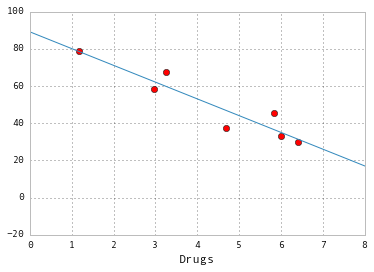

In [7]:
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
ax.plot([0,10], [b0, b0+b1*10])

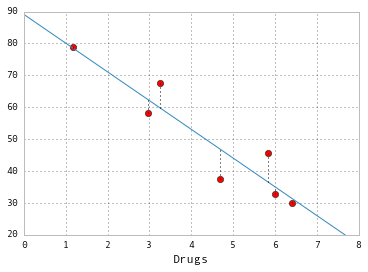

In [8]:
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8), ylim=(20, 90))
ax.plot([0,10], [b0, b0+b1*10])
for xi, yi in zip(x,y):
    ax.plot([xi]*2, [yi, b0+b1*xi], 'k:')

## Alternative loss functions

Minimizing the sum of squares is not the only criterion we can use; it is just a very popular (and successful) one. For example, we can try to minimize the sum of absolute differences:

In [9]:
sum_of_absval = lambda theta, x, y: np.sum(np.abs(y - theta[0] - theta[1]*x))

Optimization terminated successfully.
         Current function value: 31.692066
         Iterations: 137
         Function evaluations: 264

intercept: 9e+01, slope: -9.3


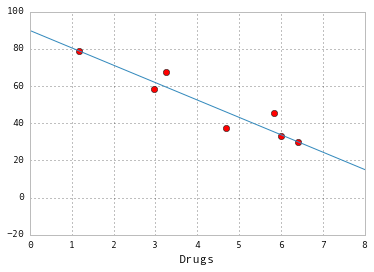

In [10]:
b0, b1 = fmin(sum_of_absval, [0,0], args=(x,y))
print('\nintercept: {0:.2}, slope: {1:.2}'.format(b0,b1))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
ax.plot([0,10], [b0, b0+b1*10])

We are not restricted to a straight-line regression model; we can represent a curved relationship between our variables by introducing **polynomial** terms. For example, a cubic model:

<div style="font-size: 150%;">  
$y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \epsilon_i$
</div>

In [11]:
sum_squares_quad = lambda theta, x, y: np.sum((y - theta[0] - theta[1]*x - theta[2]*(x**2)) ** 2)

Optimization terminated successfully.
         Current function value: 251.093792
         Iterations: 177
         Function evaluations: 319

intercept: 9.2e+01, x: -1.1e+01, x2: 0.24


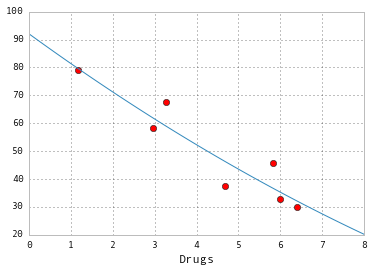

In [12]:
b0,b1,b2 = fmin(sum_squares_quad, [1,1,-1], args=(x,y))
print('\nintercept: {0:.2}, x: {1:.2}, x2: {2:.2}'.format(b0,b1,b2))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
xvals = np.linspace(0, 8, 100)
ax.plot(xvals, b0 + b1*xvals + b2*(xvals**2))

Although a polynomial model characterizes a nonlinear relationship, it is a linear problem in terms of estimation. That is, the regression model $f(y | x)$ is **linear in the parameters**.

For some data, it may be reasonable to consider polynomials of order>2. For example, consider the relationship between the number of home runs a baseball player hits and the number of runs batted in (RBI) they accumulate; one would expect the relationship is positive, but not necessarily linear.

In [13]:
sum_squares_cubic = lambda theta, x, y: np.sum((y - theta[0] - theta[1]*x - theta[2]*(x**2) 
                                  - theta[3]*(x**3)) ** 2)

Optimization terminated successfully.
         Current function value: 4274.128398
         Iterations: 230
         Function evaluations: 407


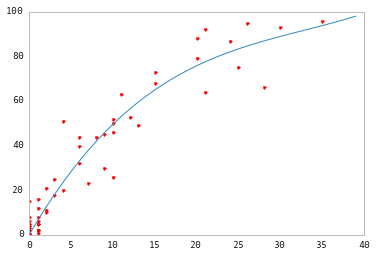

In [14]:
bb = pd.read_csv("../data/baseball.csv", index_col=0)
plt.plot(bb.hr, bb.rbi, 'r.')
b0,b1,b2,b3 = fmin(sum_squares_cubic, [0,1,-1,0], args=(bb.hr, bb.rbi))
xvals = np.arange(40)
plt.plot(xvals, b0 + b1*xvals + b2*(xvals**2) + b3*(xvals**3))

## Linear Regression with `scikit-learn`

In practice, we need not fit least squares models by hand because they are implemented generally in packages such as [`scikit-learn`](http://scikit-learn.org/) and [`statsmodels`](https://github.com/statsmodels/statsmodels/). For example, `scikit-learn` package implements least squares models in its `LinearRegression` class:

In [15]:
from sklearn import linear_model

straight_line = linear_model.LinearRegression()
straight_line.fit(x[:, np.newaxis], y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
straight_line.coef_

array([-9.00946642])

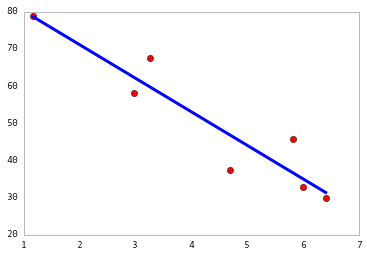

In [17]:
plt.plot(x, y, 'ro')
plt.plot(x, straight_line.predict(x[:, np.newaxis]), color='blue',
         linewidth=3)

For more general regression model building, its helpful to use a tool for describing statistical models, called `patsy`. With `patsy`, it is easy to specify the desired combinations of variables for any particular analysis, using an "R-like" syntax. `patsy` parses the formula string, and uses it to construct the approriate *design matrix* for the model.

For example, the quadratic model specified by hand above can be coded as:

In [18]:
from patsy import dmatrix

X = dmatrix('x + I(x**2)')
np.asarray(X)

array([[  1.    ,   1.17  ,   1.3689],
       [  1.    ,   2.97  ,   8.8209],
       [  1.    ,   3.26  ,  10.6276],
       [  1.    ,   4.69  ,  21.9961],
       [  1.    ,   5.83  ,  33.9889],
       [  1.    ,   6.    ,  36.    ],
       [  1.    ,   6.41  ,  41.0881]])

The `dmatrix` function returns the design matrix, which can be passed directly to the `LinearRegression` fitting method.

In [19]:
poly_line = linear_model.LinearRegression(fit_intercept=False)
poly_line.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [20]:
poly_line.coef_

array([ 91.9896726 , -10.88120698,   0.23854169])

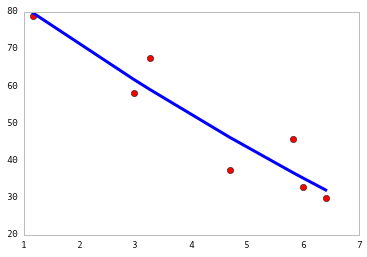

In [21]:
plt.plot(x, y, 'ro')
plt.plot(x, poly_line.predict(X), color='blue',
         linewidth=3)

## Generalized linear models

Often our data violates one or more of the linear regression assumptions:

- non-linear
- non-normal error distribution
- heteroskedasticity

this forces us to **generalize** the regression model in order to account for these characteristics.

As a motivating example, consider the Olympic medals data that we compiled earlier in the tutorial.

In [22]:
medals = pd.read_csv('../data/medals.csv')
medals.head()

,medals,population,oecd,log_population
0,1,96165,0,11.473821
1,1,281584,0,12.548186
2,6,2589043,0,14.766799
3,25,10952046,0,16.209037
4,41,18348078,1,16.725035


We expect a positive relationship between population and awarded medals, but the data in their raw form are clearly not amenable to linear regression.

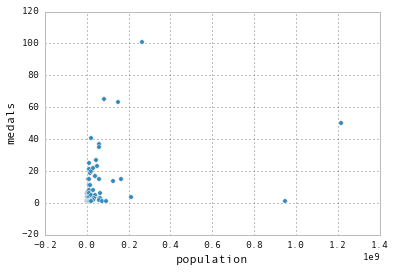

In [23]:
medals.plot(x='population', y='medals', kind='scatter')

Part of the issue is the scale of the variables. For example, countries' populations span several orders of magnitude. We can correct this by using the logarithm of population, which we have already calculated.

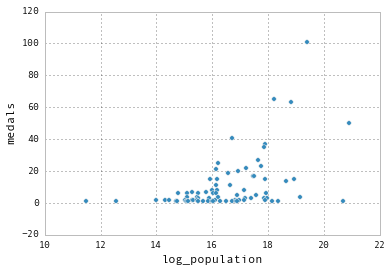

In [24]:
medals.plot(x='log_population', y='medals', kind='scatter')

This is an improvement, but the relationship is still not adequately modeled by least-squares regression.

In [25]:
linear_medals = linear_model.LinearRegression()
X = medals.log_population[:, np.newaxis]
linear_medals.fit(X, medals.medals)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

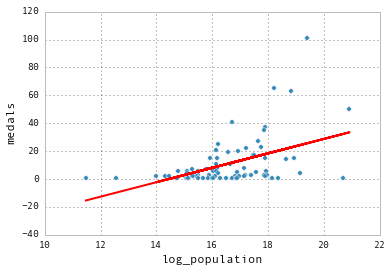

In [26]:
ax = medals.plot(x='log_population', y='medals', kind='scatter')
ax.plot(medals.log_population, linear_medals.predict(X), color='red',
         linewidth=2)

This is due to the fact that the response data are **counts**. As a result, they tend to have characteristic properties. 

- discrete
- positive
- variance grows with mean

to account for this, we can do two things: (1) model the medal count on the **log scale** and (2) assume **Poisson errors**, rather than normal.

Recall the Poisson distribution from the previous section:

$$p(y)=\frac{e^{-\lambda}\lambda^y}{y!}$$

* $Y=\{0,1,2,\ldots\}$
* $\lambda > 0$

$$E(Y) = \text{Var}(Y) = \lambda$$

So, we will model the logarithm of the expected value as a linear function of our predictors:

$$\log(\lambda) = X\beta$$

which implies the mean of the Poisson is:

$$\lambda = \exp(X\beta)$$

We can plug this into the Poisson likelihood and use maximum likelihood to estimate the regression covariates $\beta$.

$$\log L = \sum_{i=1}^n -\exp(X_i\beta) + Y_i (X_i \beta)- \log(Y_i!)$$

As we have already done, we just need to code the kernel of this likelihood, and optimize!

In [27]:
# Poisson negative log-likelhood
poisson_loglike = lambda beta, X, y: -(-np.exp(X.dot(beta)) + y*X.dot(beta)).sum()

Let's use the `assign` method to add a column of ones to the design matrix.

In [28]:
poisson_loglike([0,1], medals[['log_population']].assign(intercept=1), medals.medals)

-627.255735551737

We will use Nelder-Mead to minimize the negtive log-likelhood.

In [29]:
b1, b0 = fmin(poisson_loglike, [0,1], args=(medals[['log_population']].assign(intercept=1).values, 
                                            medals.medals.values))

Optimization terminated successfully.
         Current function value: -1381.299433
         Iterations: 68
         Function evaluations: 131


In [30]:
b0, b1

(-5.2973029170604393, 0.44873025169011005)

The resulting fit looks reasonable.

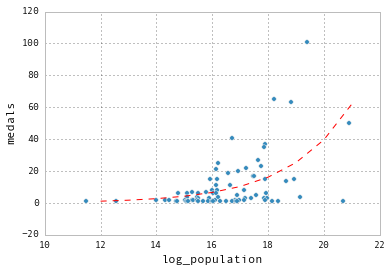

In [31]:
ax = medals.plot(x='log_population', y='medals', kind='scatter')
xvals = np.arange(12, 22)
ax.plot(xvals, np.exp(b0 + b1*xvals), 'r--')

### Exercise: Multivariate GLM

Add the OECD indicator variable to the model, and estimate the model coefficients.

In [32]:
# Write your answer here

### Interactions among variables

Interactions imply that the effect of one covariate $X_1$ on $Y$ depends on the value of another covariate $X_2$.

$$M(Y|X) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 +\beta_3 X_1 X_2$$

the effect of a unit increase in $X_1$:

$$M(Y|X_1+1, X_2) - M(Y|X_1, X_2)$$

$$\begin{align}
&= \beta_0 + \beta_1 (X_1 + 1) + \beta_2 X_2 +\beta_3 (X_1 + 1) X_2
- [\beta_0 + \beta_1 X_1 + \beta_2 X_2 +\beta_3 X_1 X_2] \\
&= \beta_1 + \beta_3 X_2
\end{align}$$

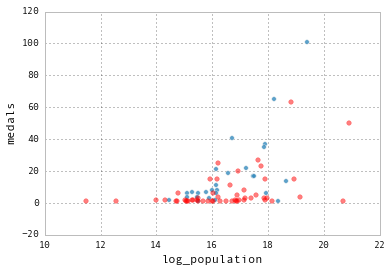

In [37]:
ax = medals[medals.oecd==1].plot(x='log_population', y='medals', kind='scatter', alpha=0.8)
medals[medals.oecd==0].plot(x='log_population', y='medals', kind='scatter', color='red', alpha=0.5, ax=ax)

Interaction can be interpreted as:

- $X_1$ interacts with $X_2$
- $X_1$ modifies the effect of $X_2$
- $X_2$ modifies the effect of $X_1$
- $X_1$ and $X_2$ are non-additive or synergistic

Let's construct a model that predicts medal count based on population size and OECD status, as well as the interaction. We can use patsy to set up the design matrix.

In [38]:
y = medals.medals
X = dmatrix('log_population * oecd', data=medals)
X

DesignMatrix with shape (79, 4)
  Intercept  log_population  oecd  log_population:oecd
          1        11.47382     0              0.00000
          1        12.54819     0              0.00000
          1        14.76680     0              0.00000
          1        16.20904     0              0.00000
          1        16.72504     1             16.72504
          1        16.14509     1             16.14509
          1        15.91733     0              0.00000
          1        13.99525     0              0.00000
          1        15.10232     1             15.10232
          1        15.29285     1             15.29285
          1        16.15816     0              0.00000
          1        16.55847     1             16.55847
          1        14.31108     0              0.00000
          1        15.47603     1             15.47603
          1        15.10551     1             15.10551
          1        16.14891     1             16.14891
          1        14.46491     1

Now, fit the model.

In [39]:
interaction_params = fmin(poisson_loglike, [0,1,1,0], args=(X, y))

Optimization terminated successfully.
         Current function value: -1434.484002
         Iterations: 279
         Function evaluations: 473


In [40]:
interaction_params

array([ 0.04545637,  0.11882267, -7.8869513 ,  0.50596676])

Notice anything odd about these estimates?

The main effect of the OECD effect is negative, which seems counter-intuitive. This is because the variable is interpreted as the OECD effect when the **log-population is zero**. This is not particularly meaningful.

We can improve the interpretability of this parameter by **centering** the log-population variable prior to entering it into the model. This will result in the OECD main effect being interpreted as the marginal effect of being an OECD country for an **average-sized** country. 

In [41]:
y = medals.medals
X = dmatrix('center(log_population) * oecd', data=medals)
X

DesignMatrix with shape (79, 4)
  Intercept  center(log_population)  oecd  center(log_population):oecd
          1                -5.03303     0                     -0.00000
          1                -3.95866     0                     -0.00000
          1                -1.74005     0                     -0.00000
          1                -0.29781     0                     -0.00000
          1                 0.21819     1                      0.21819
          1                -0.36176     1                     -0.36176
          1                -0.58952     0                     -0.00000
          1                -2.51159     0                     -0.00000
          1                -1.40453     1                     -1.40453
          1                -1.21400     1                     -1.21400
          1                -0.34869     0                     -0.00000
          1                 0.05163     1                      0.05163
          1                -2.19577     0    

In [42]:
fmin(poisson_loglike, [0,1,1,0], args=(X, y))

Optimization terminated successfully.
         Current function value: -1489.494828
         Iterations: 337
         Function evaluations: 567


array([ 1.72485034,  0.41894574,  0.74422496,  0.20845437])

## Model Selection

How do we choose among competing models for a given dataset? More parameters are not necessarily better, from the standpoint of model fit. For example, fitting a 6th order polynomial to the LSD example certainly results in an overfit.

Optimization terminated successfully.
         Current function value: 304.786763
         Iterations: 830
         Function evaluations: 1284


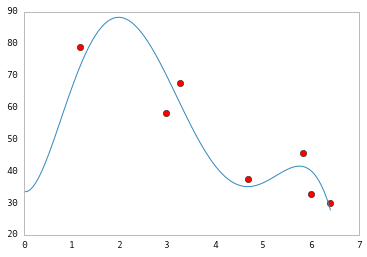

In [43]:
def calc_poly(params, data):
        x = np.c_[[data**i for i in range(len(params))]]
        return np.dot(params, x)

x, y = lsd_and_math.T.values
    
sum_squares_poly = lambda theta, x, y: np.sum((y - calc_poly(theta, x)) ** 2)
betas = fmin(sum_squares_poly, np.zeros(7), args=(x,y), maxiter=1e6)
plt.plot(x, y, 'ro')
xvals = np.linspace(0, max(x), 100)
plt.plot(xvals, calc_poly(betas, xvals))

One approach is to use an information-theoretic criterion to select the most appropriate model. For example **Akaike's Information Criterion (AIC)** balances the fit of the model (in terms of the likelihood) with the number of parameters required to achieve that fit. We can easily calculate AIC as:

$$AIC = n \log(\hat{\sigma}^2) + 2p$$

where $p$ is the number of parameters in the model and $\hat{\sigma}^2 = RSS/(n-p-1)$.

Notice that as the number of parameters increase, the residual sum of squares goes down, but the second term (a penalty) increases.

To apply AIC to model selection, we choose the model that has the **lowest** AIC value.

In [44]:
n = len(x)

aic = lambda rss, p, n: n * np.log(rss/(n-p-1)) + 2*p

RSS1 = sum_of_squares(fmin(sum_of_squares, [0,1], args=(x,y)), x, y)
RSS2 = sum_squares_quad(fmin(sum_squares_quad, [1,1,-1], args=(x,y)), x, y)

print('\nModel 1: {0}\nModel 2: {1}'.format(aic(RSS1, 2, n), aic(RSS2, 3, n)))

Optimization terminated successfully.
         Current function value: 253.881329
         Iterations: 97
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: 251.093792
         Iterations: 177
         Function evaluations: 319

Model 1: 33.05400811127588
Model 2: 36.99049978705


Hence, on the basis of "information distance", we would select the 2-parameter (linear) model.

### Exercise: Olympic medals model selection

Use AIC to select the best model from the following set of Olympic medal prediction models:

- population only
- population and OECD
- interaction model

For these models, use the alternative form of AIC, which uses the log-likelhood rather than the residual sums-of-squares:

$$AIC = -2 \log(L) + 2p$$

In [45]:
# Write your answer here

## Logistic Regression

Fitting a line to the relationship between two variables using the least squares approach is sensible when the variable we are trying to predict is continuous, but what about when the data are dichotomous?

- male/female
- pass/fail
- died/survived

Let's consider the problem of predicting survival in the Titanic disaster, based on our available information. For example, lets say that we want to predict survival as a function of the fare paid for the journey.

In [46]:
titanic = pd.read_excel("../data/titanic.xls", "titanic")
titanic.name

0                           Allen, Miss. Elisabeth Walton
1                          Allison, Master. Hudson Trevor
2                            Allison, Miss. Helen Loraine
3                    Allison, Mr. Hudson Joshua Creighton
4         Allison, Mrs. Hudson J C (Bessie Waldo Daniels)
5                                     Anderson, Mr. Harry
6                       Andrews, Miss. Kornelia Theodosia
7                                  Andrews, Mr. Thomas Jr
8           Appleton, Mrs. Edward Dale (Charlotte Lamson)
9                                 Artagaveytia, Mr. Ramon
10                                 Astor, Col. John Jacob
11      Astor, Mrs. John Jacob (Madeleine Talmadge Force)
12                          Aubart, Mme. Leontine Pauline
13                           Barber, Miss. Ellen "Nellie"
14                   Barkworth, Mr. Algernon Henry Wilson
15                                    Baumann, Mr. John D
16                               Baxter, Mr. Quigg Edmond
17        Baxt

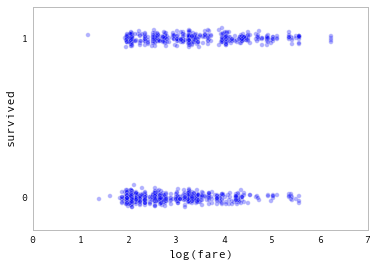

In [47]:
jitter = np.random.normal(scale=0.02, size=len(titanic))
plt.scatter(np.log(titanic.fare), titanic.survived + jitter, alpha=0.3)
plt.yticks([0,1])
plt.ylabel("survived")
plt.xlabel("log(fare)")

I have added random jitter on the y-axis to help visualize the density of the points, and have plotted fare on the log scale.

Clearly, fitting a line through this data makes little sense, for several reasons. First, for most values of the predictor variable, the line would predict values that are not zero or one. Second, it would seem odd to choose least squares (or similar) as a criterion for selecting the best line.

In [48]:
x = np.log(titanic.fare[titanic.fare>0])
y = titanic.survived[titanic.fare>0]
betas_titanic = fmin(sum_of_squares, [1,1], args=(x,y))

Optimization terminated successfully.
         Current function value: 277.621917
         Iterations: 55
         Function evaluations: 103


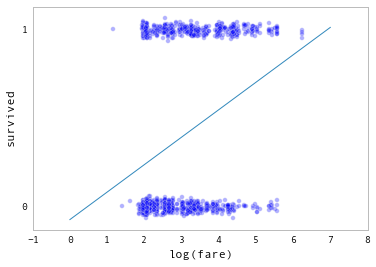

In [49]:
jitter = np.random.normal(scale=0.02, size=len(titanic))
plt.scatter(np.log(titanic.fare), titanic.survived + jitter, alpha=0.3)
plt.yticks([0,1])
plt.ylabel("survived")
plt.xlabel("log(fare)")
plt.plot([0,7], [betas_titanic[0], betas_titanic[0] + betas_titanic[1]*7.])

If we look at this data, we can see that for most values of `fare`, there are some individuals that survived and some that did not. However, notice that the cloud of points is denser on the "survived" (`y=1`) side for larger values of fare than on the "died" (`y=0`) side.

### Stochastic model

Rather than model the binary outcome explicitly, it makes sense instead to model the *probability* of death or survival in a **stochastic** model. Probabilities are measured on a continuous [0,1] scale, which may be more amenable for prediction using a regression line. We need to consider a different probability model for this exerciese however; let's consider the **Bernoulli** distribution as a generative model for our data:

<div style="font-size: 120%;">  
$$f(y|p) = p^{y} (1-p)^{1-y}$$ 
</div>  

where $y = \{0,1\}$ and $p \in [0,1]$. So, this model predicts whether $y$ is zero or one as a function of the probability $p$. Notice that when $y=1$, the $1-p$ term disappears, and when $y=0$, the $p$ term disappears.

So, the model we want to fit should look something like this:

<div style="font-size: 120%;">  
$$p_i = \beta_0 + \beta_1 x_i + \epsilon_i$$
</div>

However, since $p$ is constrained to be between zero and one, it is easy to see where a linear (or polynomial) model might predict values outside of this range. We can modify this model sligtly by using a **link function** to transform the probability to have an unbounded range on a new scale. Specifically, we can use a **logit transformation** as our link function:

<div style="font-size: 120%;">  
$$\text{logit}(p) = \log\left[\frac{p}{1-p}\right] = x$$
</div>

Here's a plot of $p/(1-p)$

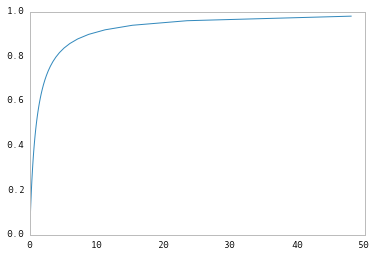

In [50]:
logit = lambda p: np.log(p/(1.-p))
unit_interval = np.linspace(0,1)
plt.plot(unit_interval/(1-unit_interval), unit_interval)

And here's the logit function:

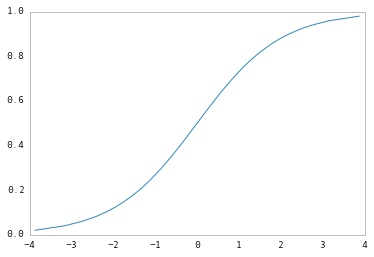

In [51]:
plt.plot(logit(unit_interval), unit_interval)

The inverse of the logit transformation is:

<div style="font-size: 150%;">  
$$p = \frac{1}{1 + \exp(-x)}$$
</div>

In [52]:
invlogit = lambda x: 1. / (1 + np.exp(-x))

So, now our model is:

<div style="font-size: 120%;">  
$$\text{logit}(p_i) = \beta_0 + \beta_1 x_i + \epsilon_i$$
</div>

We can fit this model using maximum likelihood. Our likelihood, again based on the Bernoulli model is:

<div style="font-size: 120%;">  
$$L(y|p) = \prod_{i=1}^n p_i^{y_i} (1-p_i)^{1-y_i}$$
</div>

which, on the log scale is:

<div style="font-size: 120%;">  
$$l(y|p) = \sum_{i=1}^n y_i \log(p_i) + (1-y_i)\log(1-p_i)$$
</div>

We can easily implement this in Python, keeping in mind that `fmin` minimizes, rather than maximizes functions:

In [53]:
def logistic_like(theta, x, y):
    
    p = invlogit(theta[0] + theta[1] * x)
    
    # Return negative of log-likelihood
    return -np.sum(y * np.log(p) + (1-y) * np.log(1 - p))

Remove null values from variables

In [54]:
x, y = titanic[titanic.fare.notnull()][['fare', 'survived']].values.T

... and fit the model.

In [55]:
b0, b1 = fmin(logistic_like, [0.5,0], args=(x,y))
b0, b1

Optimization terminated successfully.
         Current function value: 827.015955
         Iterations: 47
         Function evaluations: 93


(-0.88238984528338194, 0.012452067664164127)

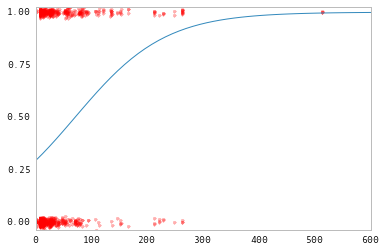

In [56]:
jitter = np.random.normal(scale=0.01, size=len(x))
plt.plot(x, y+jitter, 'r.', alpha=0.3)
plt.yticks([0,.25,.5,.75,1])
xvals = np.linspace(0, 600)
plt.plot(xvals, invlogit(b0+b1*xvals))

As with our least squares model, we can easily fit logistic regression models in `scikit-learn`, in this case using the `LogisticRegression`.

In [57]:
logistic = linear_model.LogisticRegression()
logistic.fit(x[:, np.newaxis], y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [58]:
logistic.coef_

array([[ 0.0123847]])

### Exercise: multivariate logistic regression

Which other variables might be relevant for predicting the probability of surviving the Titanic? Generalize the model likelihood to include 2 or 3 other covariates from the dataset.

In [59]:
# Write your answer here